In [306]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [307]:
# from datasets import mnist_data_loader, cifar10_data_loader, celeb_dataset_loader

In [308]:
# from jax import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [309]:
import yaml
import glob
import copy

In [310]:
meta_files = glob.glob('FID/*/*.yaml')

meta_datas = {}
for path in meta_files:
    with open(path) as f:
        meta = yaml.safe_load(f)
    name = path[4:-10]
    meta_datas[name] = meta

In [311]:
def get_fids(dataset_name):
    files = dict([(key, val) for key, val in meta_datas.items() if dataset_name in key])
    ans = {}
    for key, val in files.items():
        
        df = pd.DataFrame(val['settings'])
        df['iteration_number'] = val['iteration_number']
        df['index'] = df['path'].apply(lambda x: int(x.split('_')[-1]))
        
        if('glow' in key):
            if(df.shape[0] > 1):
                df = df[df['index'] > 0]
        else:
            # Keep the last 15 folders
            max_index = df['index'].max()
            df = df[df['index'] > max_index - 15]
        
        ans[key] = df
    return ans

In [312]:
def plot_fids(all_scores, save_path=None):    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    
    # Plot the NF first
    nf_key = [key for key in all_scores.keys() if 'glow' in key][0]
    NF_score = all_scores[nf_key]['score'].to_numpy()[0]
    ax.axhline(NF_score, c='black', label='NF', linestyle=':')
    
    # Plot the remaining lines
    non_nf_keys = [key for key in all_scores if key is not nf_key]
    sorted_keys = sorted(non_nf_keys, key=lambda x: int(x.split('_')[-1]))
    styles = ['-', '-.', '--', (0, (5, 10)), (0, (3, 5, 1, 5))]
    for key, ls in zip(sorted_keys, styles):
        df = all_scores[key]
        label = 'NIF-%s'%key.split('_')[-1]
        
        df[df['s'] <= 1.0].plot(ax=ax, x='s', y='score', label=label, linestyle=ls)

    ax.set_xlabel('s', fontsize=14)
    ax.set_ylabel('FID', fontsize=14)
    ax.set_xlim(0.0, 1.0)
        
    ax.legend()
    
    if(save_path is not None):
        print('saved to', save_path)
        plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
        plt.savefig(save_path, bbox_inches='tight', format='pdf')

In [313]:
celeba_scores = get_fids('celeba')
cifar_scores = get_fids('cifar')
mnist_scores = get_fids('mnist')

In [314]:
pwd

'/home/eddie/NoisyInjectiveFlows'

saved to Results/celeba_fid_vary_s.pdf


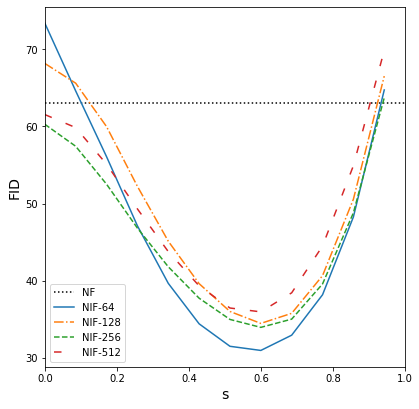

In [321]:
save_path = 'Results/celeba_fid_vary_s.pdf'
plot_fids(celeba_scores, save_path=save_path)

saved to Results/cifar_fid_vary_s.pdf


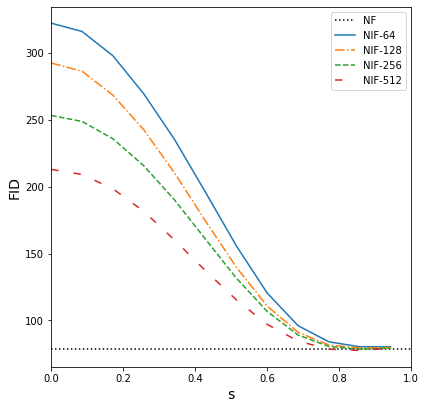

In [322]:
save_path = 'Results/cifar_fid_vary_s.pdf'
plot_fids(cifar_scores, save_path=save_path)

saved to Results/fmnist_fid_vary_s.pdf


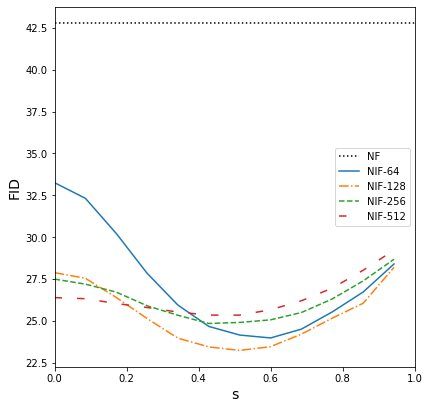

In [323]:
save_path = 'Results/fmnist_fid_vary_s.pdf'
plot_fids(mnist_scores, save_path=save_path)

In [331]:
ls Experiments/celeba_64/186000/checkpoint

keys.p  losses.csv  model_state.npz  opt_state.npz


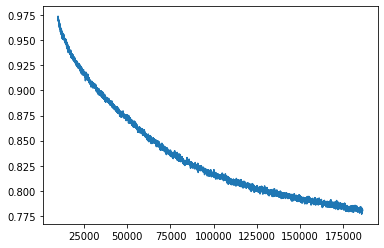

In [344]:
csvs = []


pd.read_csv('Experiments/celeba_64/186000/checkpoint/losses.csv', header=None)[1].ewm(alpha=0.01).mean()[10000:].plot()

In [351]:
losses = ['Experiments/celeba_glow/130000/checkpoint/losses.csv',
'Experiments/celeba_64/186000/checkpoint/losses.csv',
'Experiments/celeba_128/170000/checkpoint/losses.csv',
'Experiments/celeba_256/180000/checkpoint/losses.csv',
'Experiments/celeba_512/130000/checkpoint/losses.csv']

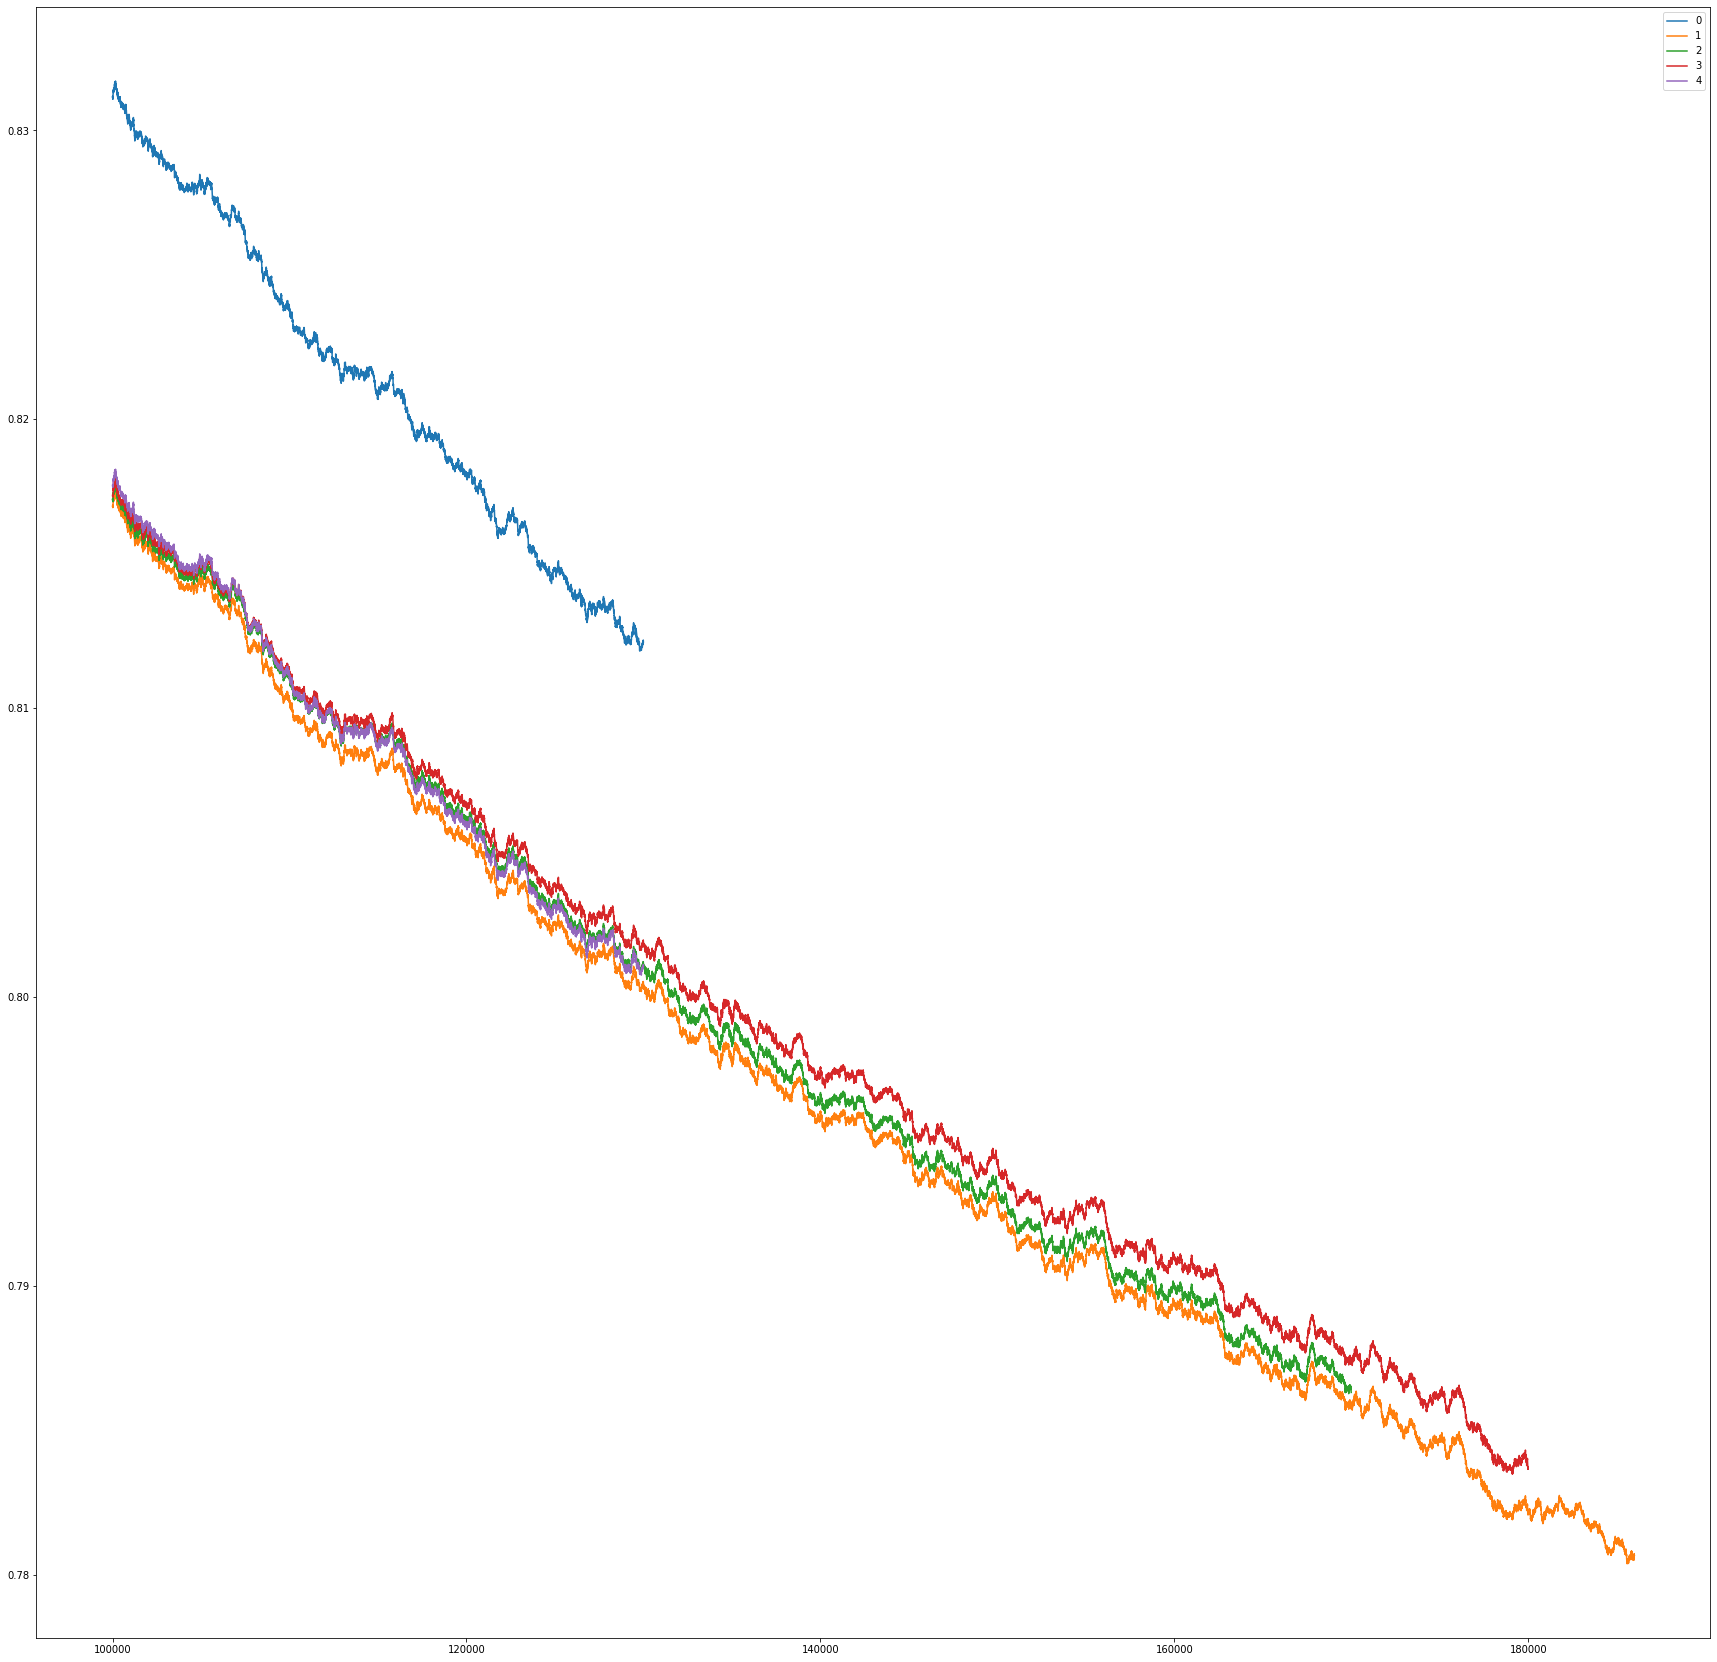

In [357]:
plt.figure().set_size_inches(30, 30)
for i, file in enumerate(losses):
    pd.read_csv(file, header=None)[1].ewm(alpha=0.001).mean()[100000:].plot(label=i)
plt.legend()
plt.show()